# Telco Customer Churn for ICP4D

We'll use this notebook to create a machine learning model to predict customer churn.

# 1.0 Install required packages

In [18]:
!pip install --user watson-machine-learning-client --upgrade | tail -n 1
!pip install --user pyspark==2.3.3 --upgrade|tail -n 1

# 2.0 Load and Clean data
We'll load our data as a pandas data frame.

* Highlight the cell below by clicking it.
* Click the `10/01` "Find data" icon in the upper right of the notebook.
* If you are using [Virtualized data], begin by choosing the `Files` tab. Then choose your virtualized data (i.e. User<xyz>.billingProductCustomers), click `Insert to code` and choose `Insert Pandas DataFrame`.
* If you are using this code pattern without virtualized data, add the locally uploaded file `WA_Fn-UseC_-Telco-Customer-Churn.csv` by choosing the 'Files` tab. Then choose the `WA_Fn-UseC_-Telco-Customer-Churn.csv`. Click `Insert to code` and choose `Insert Pandas DataFrame`.
* The code to bring the data into the notebook environment and create a Pandas DataFrame will be added to the cell below.
* Run the cell


In [19]:

# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.

from project_lib import Project
project = Project.access()
USER999_BILLINGPRODUCTSCUSTOMERSV2_credentials = project.get_connected_data(name="USER999.BILLINGPRODUCTSCUSTOMERSV2")

import jaydebeapi, pandas as pd
USER999_BILLINGPRODUCTSCUSTOMERSV2_connection = jaydebeapi.connect('com.ibm.db2.jcc.DB2Driver',
    '{}://{}:{}/{}:user={};password={};'.format('jdbc:db2',
    USER999_BILLINGPRODUCTSCUSTOMERSV2_credentials['host'],
    USER999_BILLINGPRODUCTSCUSTOMERSV2_credentials['port'],
    USER999_BILLINGPRODUCTSCUSTOMERSV2_credentials['database'],
    USER999_BILLINGPRODUCTSCUSTOMERSV2_credentials['username'],
    USER999_BILLINGPRODUCTSCUSTOMERSV2_credentials['password']))

query = 'SELECT * FROM USER999.BILLINGPRODUCTSCUSTOMERSV2'
data_df_1 = pd.read_sql(query, con=USER999_BILLINGPRODUCTSCUSTOMERSV2_connection)
data_df_1.head()

# You can close the database connection with the following code.
# USER999_BILLINGPRODUCTSCUSTOMERSV2_connection.close()
# To learn more about the jaydebeapi package, please read the documentation: https://pypi.org/project/JayDeBeApi/


,Churn,Contract,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,PaymentMethod,...,StreamingMovies,StreamingTV,TechSupport,TotalCharges,customerID,Dependents,Partner,SeniorCitizen,gender,tenure
0,No,Two year,No internet service,No,25.10,Yes,No internet service,No internet service,No,Mailed check,...,No internet service,No internet service,No internet service,1697.70,1767-CJKBA,No,No,0,Male,66
1,No,Two year,Yes,Fiber optic,114.70,Yes,Yes,Yes,Yes,Bank transfer (automatic),...,Yes,Yes,Yes,7849.85,6445-TNRXS,Yes,Yes,0,Male,68
2,No,Month-to-month,Yes,DSL,49.15,No phone service,No,No,No,Electronic check,...,Yes,Yes,No,649.40,4581-LNWUM,No,No,0,Female,13
3,No,One year,No,Fiber optic,80.90,No,No,No,Yes,Electronic check,...,Yes,No,No,4557.50,4869-EPIUS,No,Yes,0,Male,56
4,Yes,Month-to-month,No,Fiber optic,79.45,No,Yes,Yes,Yes,Electronic check,...,No,No,No,3013.05,9948-YPTDG,No,Yes,0,Male,38


In [20]:
# Place cursor below and insert the Pandas DataFrame for the Telco churn data
import pandas as pd
df_data_2 = pd.read_csv('/project_data/data_asset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_data_2.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We'll use the Pandas naming convention `df` for our DataFrame.  Make sure that the cell below uses the name for the dataframe used above, i.e df1, df2,... dfX for the remote data using Data Virtualization, or df_data1, df_data2, ... if using local data.

In [21]:
# df = df1
df = df_data_2

### 2.1 Drop CustomerID feature (column)

In [22]:
df = df.drop('customerID', axis=1)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2.2 Examine the data types of the features

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 1.1+ MB


### 2.3 Convert TotalCharges column to numeric as it is detected as object

In [24]:
totalCharges = df.columns.get_loc("TotalCharges")
print(totalCharges)

18


In [25]:
new_col = pd.to_numeric(df.iloc[:, totalCharges], errors='coerce')
new_col

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
5        820.50
6       1949.40
7        301.90
8       3046.05
9       3487.95
10       587.45
11       326.80
12      5681.10
13      5036.30
14      2686.05
15      7895.15
16      1022.95
17      7382.25
18       528.35
19      1862.90
20        39.65
21       202.25
22        20.15
23      3505.10
24      2970.30
25      1530.60
26      4749.15
27        30.20
28      6369.45
29      1093.10
         ...   
7013    3756.40
7014    3645.75
7015    2874.45
7016      49.95
7017    1020.75
7018      70.65
7019     826.00
7020     239.00
7021     727.80
7022    7544.30
7023    6479.40
7024    3626.35
7025    1679.40
7026     403.35
7027     931.55
7028    4326.25
7029     263.05
7030      39.25
7031    3316.10
7032      75.75
7033    2625.25
7034    6886.25
7035    1495.10
7036     743.30
7037    1419.40
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Leng

### 2.4 Modify our dataframe to reflect the new datatype

In [26]:
df.iloc[:, totalCharges] = pd.Series(new_col)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No




### 2.5 Any NaN values should be removed to create a more accurate model. Prior examination shows NaN values for `TotalCharges`

In [27]:
# Check if we have any NaN values
df.isnull().values.any()

True

Set `nan_column` to the column number for TotalCharges (starting at 0).

In [28]:
nan_column = df.columns.get_loc("TotalCharges")
print(nan_column)

18


In [29]:
# Handle missing values for nan_column (TotalCharges)

from sklearn.preprocessing import Imputer

imp = Imputer(missing_values="NaN", strategy="mean")

df.iloc[:, nan_column] = imp.fit_transform(df.iloc[:, nan_column].values.reshape(-1, 1))
df.iloc[:, nan_column] = pd.Series(df.iloc[:, nan_column])

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [30]:
# Check if we have any NaN values
df.isnull().values.any()

False

### 2.6 Visualize data

In [31]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn import metrics

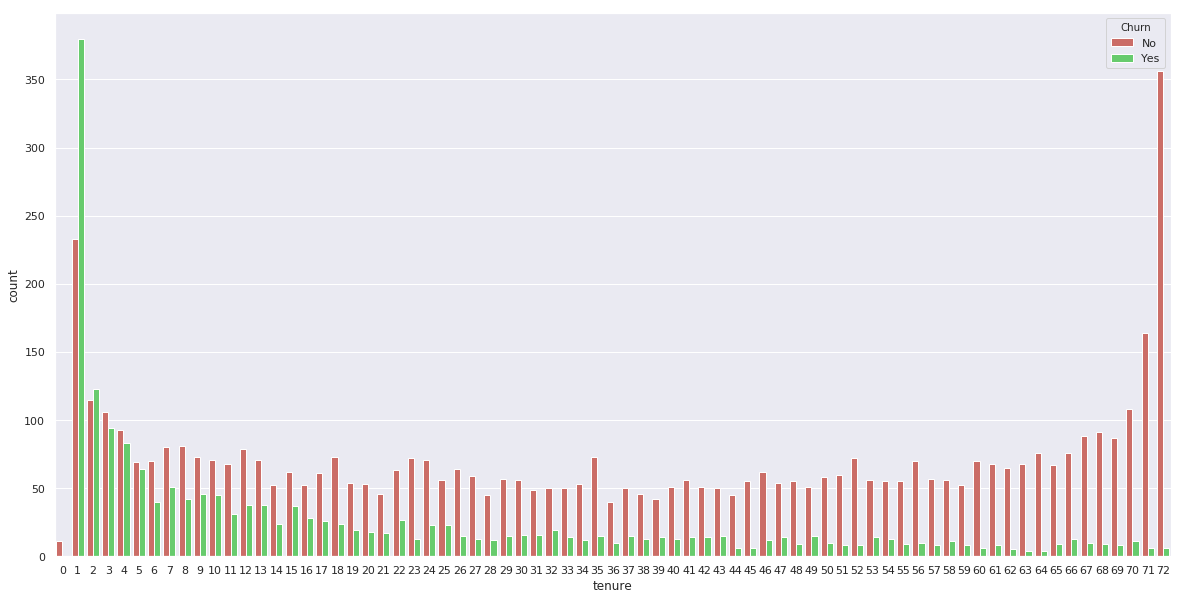

In [32]:
# Plot Tenure Frequency count
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="tenure", hue="Churn", data=df)

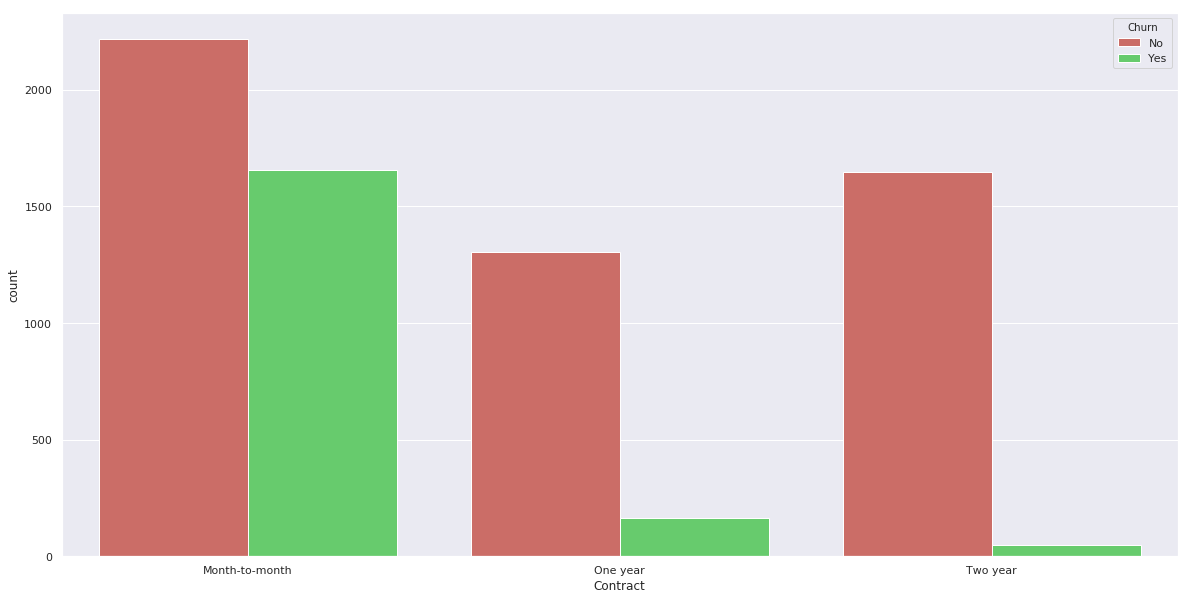

In [33]:
# Plot Tenure Frequency count
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="Contract", hue="Churn", data=df)

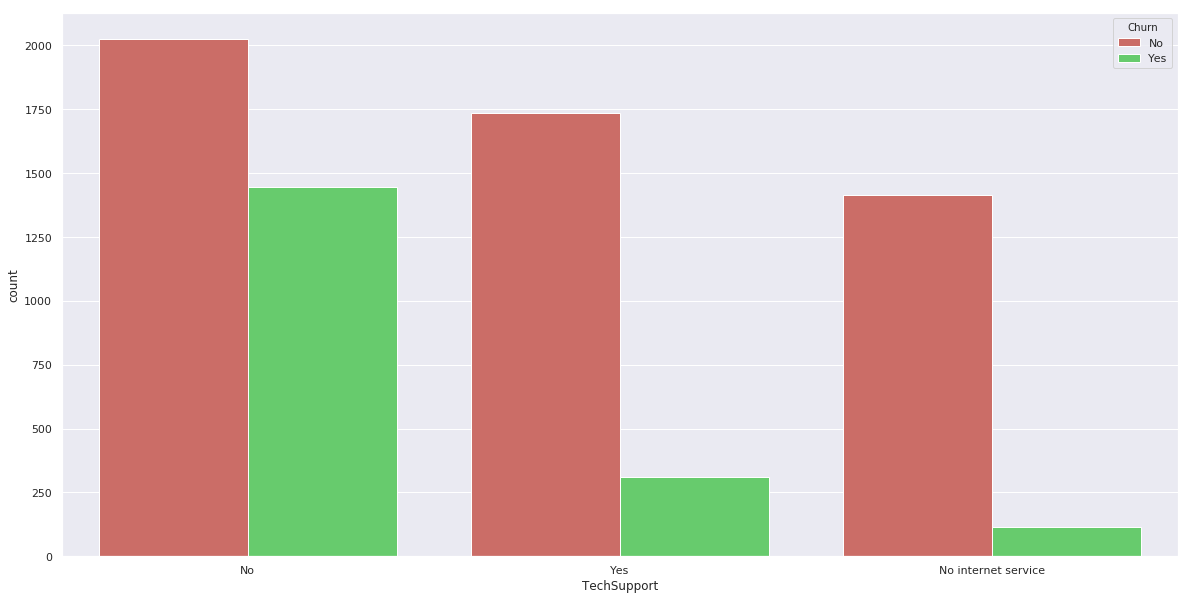

In [34]:
# Plot Tenure Frequency count
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="TechSupport", hue="Churn", data=df)


/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


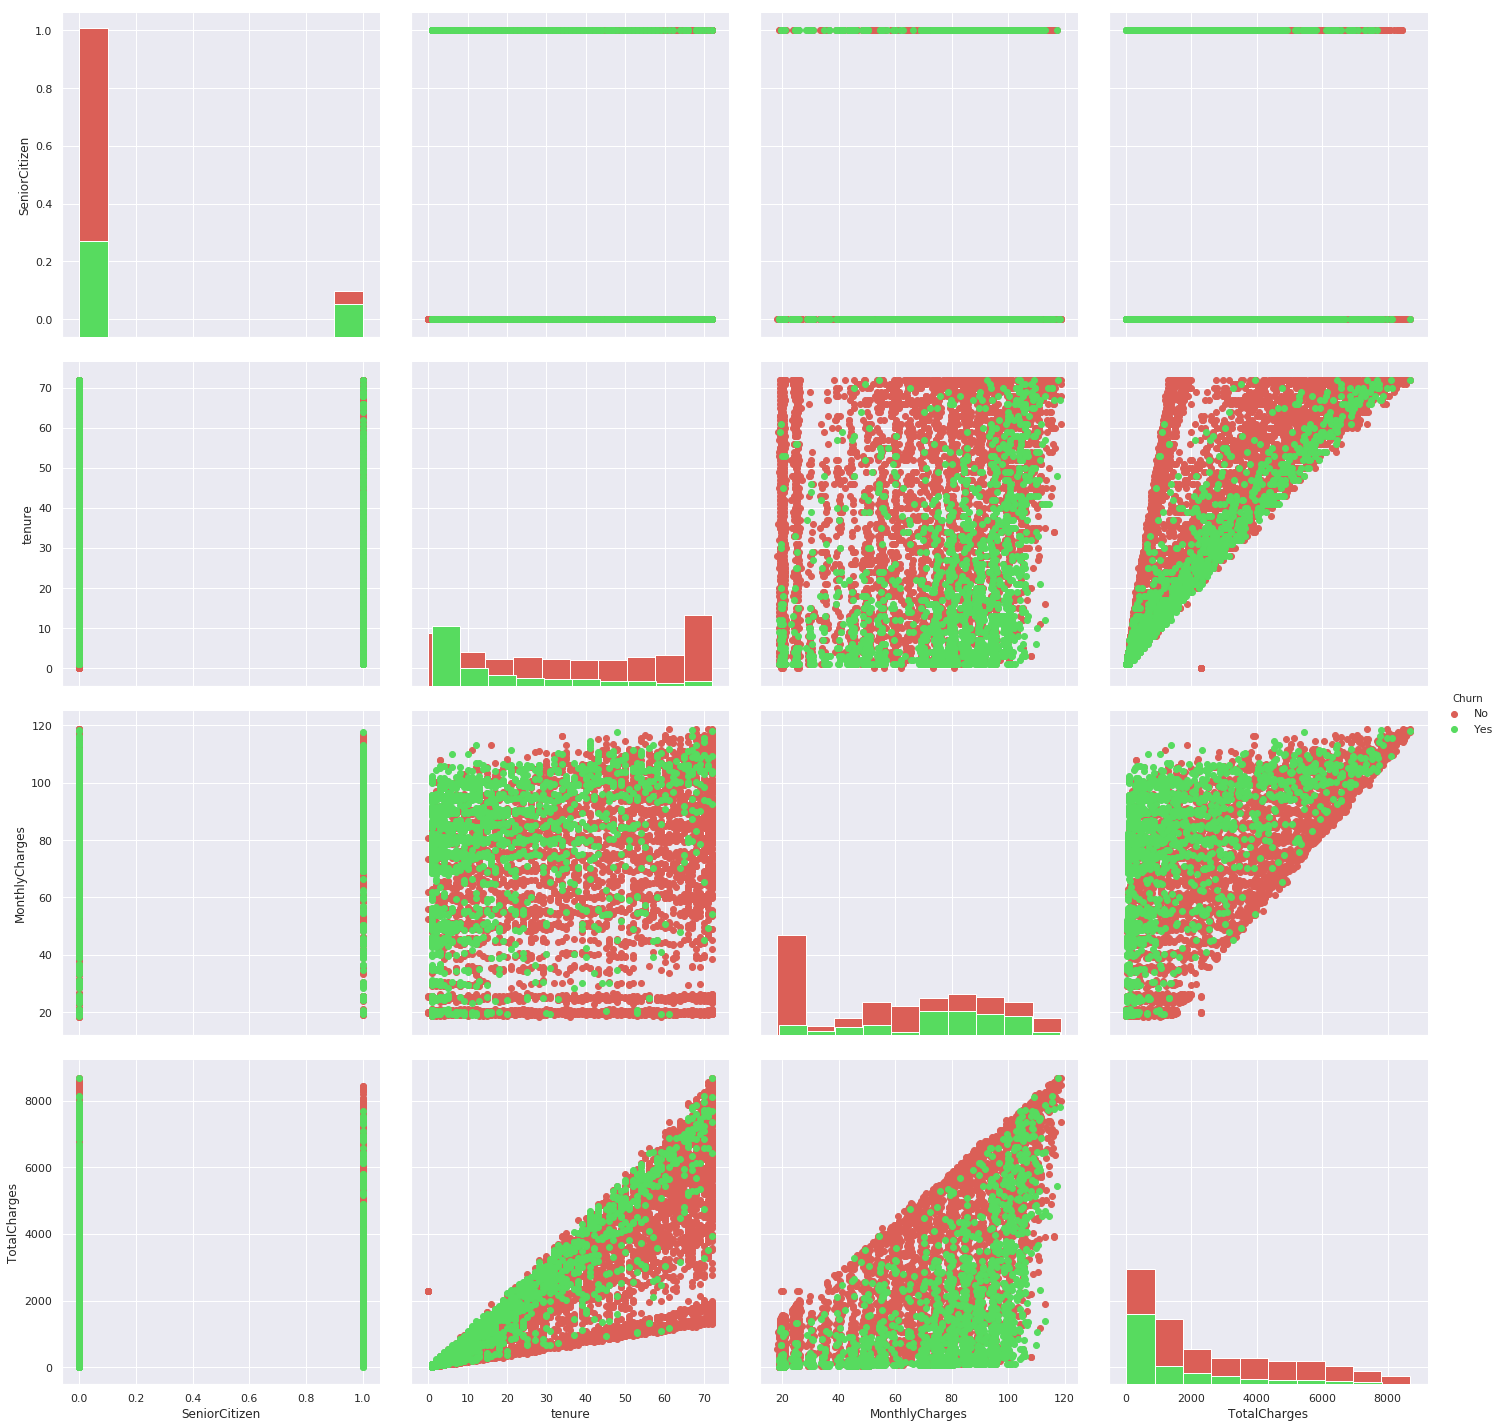

In [35]:
# Create Grid for pairwise relationships
gr = sns.PairGrid(df, size=5, hue="Churn")
gr = gr.map_diag(plt.hist)
gr = gr.map_offdiag(plt.scatter)
gr = gr.add_legend()

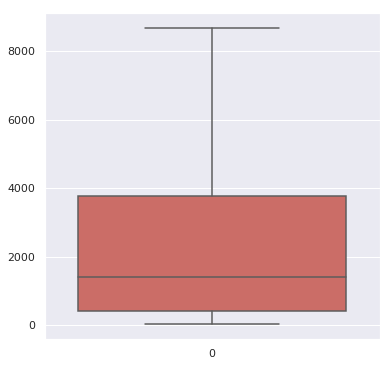

In [37]:
# Set up plot size
fig, ax = plt.subplots(figsize=(6,6))

# Attributes destribution
a = sns.boxplot(orient="v", palette="hls", data=df.iloc[:, totalCharge], fliersize=14)


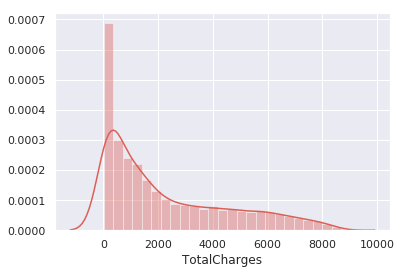

In [38]:
# Total Charges data distribution
histogram = sns.distplot(df.iloc[:, totalCharge], hist=True)
plt.show()

In [39]:
tenure  = df.columns.get_loc("tenure")
print(tenure)

4


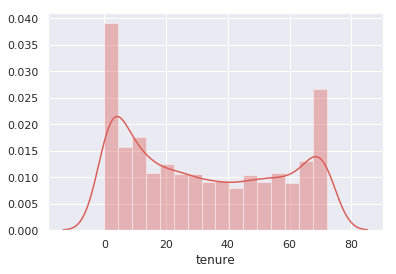

In [40]:
# Tenure data distribution
histogram = sns.distplot(df.iloc[:, tenure], hist=True)
plt.show()

In [41]:
monthly = df.columns.get_loc("MonthlyCharges")
print(monthly)

17


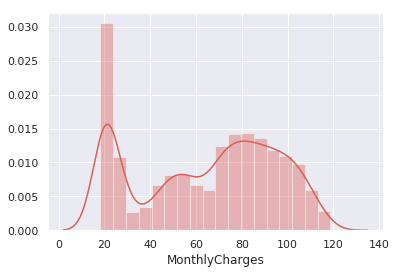

In [42]:
# Monthly Charges data distribution
histogram = sns.distplot(df.iloc[:, monthly], hist=True)
plt.show()


Understand Data Distribution¶


# 3.0 Create a model

In [43]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges=29.85, Churn='No')

### 3.1 Split the data into training and test sets

In [44]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 5662
Number of records for evaluation: 1381


### 3.2 Examine the Spark DataFrame Schema
Look at the data types to determine requirements for feature engineering

In [45]:
spark_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

In [46]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model


si_gender = StringIndexer(inputCol = 'gender', outputCol = 'gender_IX')
si_Partner = StringIndexer(inputCol = 'Partner', outputCol = 'Partner_IX')
si_Dependents = StringIndexer(inputCol = 'Dependents', outputCol = 'Dependents_IX')
si_PhoneService = StringIndexer(inputCol = 'PhoneService', outputCol = 'PhoneService_IX')
si_MultipleLines = StringIndexer(inputCol = 'MultipleLines', outputCol = 'MultipleLines_IX')
si_InternetService = StringIndexer(inputCol = 'InternetService', outputCol = 'InternetService_IX')
si_OnlineSecurity = StringIndexer(inputCol = 'OnlineSecurity', outputCol = 'OnlineSecurity_IX')
si_OnlineBackup = StringIndexer(inputCol = 'OnlineBackup', outputCol = 'OnlineBackup_IX')
si_DeviceProtection = StringIndexer(inputCol = 'DeviceProtection', outputCol = 'DeviceProtection_IX')
si_TechSupport = StringIndexer(inputCol = 'TechSupport', outputCol = 'TechSupport_IX')
si_StreamingTV = StringIndexer(inputCol = 'StreamingTV', outputCol = 'StreamingTV_IX')
si_StreamingMovies = StringIndexer(inputCol = 'StreamingMovies', outputCol = 'StreamingMovies_IX')
si_Contract = StringIndexer(inputCol = 'Contract', outputCol = 'Contract_IX')
si_PaperlessBilling = StringIndexer(inputCol = 'PaperlessBilling', outputCol = 'PaperlessBilling_IX')
si_PaymentMethod = StringIndexer(inputCol = 'PaymentMethod', outputCol = 'PaymentMethod_IX')


In [47]:
si_Label = StringIndexer(inputCol="Churn", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

### 3.4 Create a single vector

In [48]:
va_features = VectorAssembler(inputCols=['gender_IX',  'SeniorCitizen', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', \
                                         'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', \
                                         'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'TotalCharges', 'MonthlyCharges'], outputCol="features")

### 3.5 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

In [49]:
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_gender, si_Partner, si_Dependents, si_PhoneService, si_MultipleLines, si_InternetService, si_OnlineSecurity, si_OnlineBackup, si_DeviceProtection, \
                            si_TechSupport, si_StreamingTV, si_StreamingMovies, si_Contract, si_PaperlessBilling, si_PaymentMethod, si_Label, va_features, \
                            classifier, label_converter])

model = pipeline.fit(train_data)

In [50]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.699278


# 4.0 Save the model and test data

Add a unique name for MODEL_NAME.

In [51]:
MODEL_NAME = "my-model my-date"

### 4.1 Save the model to ICP4D local Watson Machine Learning

In [52]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials = {
                   "url": "https://zen-cpd-zen.apps.os-workshop-nov22.vz-cpd-nov22.com",
                   "username": "*****",
                   "password" : "*****",
                   "instance_id": "wml_local",
                   "version" : "2.5.0"
                  }

client = WatsonMachineLearningAPIClient(wml_credentials)

In [54]:
client.spaces.list()

------------------------------------  --------------------  ------------------------
GUID                                  NAME                  CREATED
a0131e2d-f39d-4056-9d7c-01f5b1cf9693  sda-deployment-space  2019-11-20T21:32:02.192Z
------------------------------------  --------------------  ------------------------


### Use the desired space as the `default_space`

In [55]:
client.set.default_space('*******')

'SUCCESS'

In [56]:
# Store our model
model_props = {client.repository.ModelMetaNames.NAME: MODEL_NAME,
               client.repository.ModelMetaNames.RUNTIME_UID : "spark-mllib_2.3",
               client.repository.ModelMetaNames.TYPE : "mllib_2.3"}
published_model = client.repository.store_model(model=model, pipeline=pipeline, meta_props=model_props, training_data=train_data)

In [57]:
# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()
client.deployments.list()

# client.repository.delete('GUID of stored model')
# client.deployments.delete('GUID of deployed model')


------------------------------------  ---------------  ------------------------  ---------
GUID                                  NAME             CREATED                   TYPE
1788466d-4378-4f48-937d-152dc454f4a5  sda model 11-20  2019-11-20T21:36:21.002Z  mllib_2.3
------------------------------------  ---------------  ------------------------  ---------
----  ----  -----  -------  -------------
GUID  NAME  STATE  CREATED  ARTIFACT_TYPE
----  ----  -----  -------  -------------


### 4.2 Write the test data without label to a .csv so that we can later use it for batch scoring

In [58]:
write_score_CSV=test_data.toPandas().drop(['Churn'], axis=1)
write_score_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLBatchScore.csv', sep=',', index=False)

### 4.3 Write the test data to a .csv so that we can later use it for evaluation

In [59]:
write_eval_CSV=test_data.toPandas()
write_eval_CSV.to_csv('/project_data/data_asset/TelcoCustomerSparkMLEval.csv', sep=',', index=False)

## Congratulations, you have created a model based on customer churn data, and deployed it to Watson Machine Learning!